# Face Liveliness Detection
MobileNetV2 is used as the classifier

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf


import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

color = sns.color_palette()
%matplotlib inline


seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)


Configuring directories

In [3]:
root = "../input/lcc-fasd"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['LCC_FASD']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [4]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1223   405   314
spoof   7076  2543  7266


# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [5]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [6]:

train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 8299 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [7]:

print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


# Generate Model

In [32]:
# pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
#                                         include_top = False,
#                                         weights = 'imagenet')

# freeze_before = None  
# if freeze_before:
#     for layer in pretrain_net.layers:
#         if layer.name == freeze_before:
#             break
#         else:
#             layer.trainable = False


In [33]:

# x = pretrain_net.output
# x = Conv2D(32, (3, 3), activation='relu')(x)
# x = Dropout(rate=0.2, name='extra_dropout1')(x)
# x = GlobalAveragePooling2D()(x)
# # x = Dense(units=128, activation='relu', name='extra_fc1')(x)
# # x = Dropout(rate=0.2, name='extra_dropout1')(x)
# x = Dense(1, activation='sigmoid', name='classifier')(x)

# model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
# print(model.summary())


In [36]:
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, SeparableConv2D, BatchNormalization, 
    LeakyReLU, Multiply, GlobalMaxPooling2D, Add
)
from tensorflow.keras.regularizers import l2

# Load the MobileNetV2 pretrained model
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')

# Freeze layers up to a certain point
freeze_before = 'block_13_expand'  # Example: Unfreeze layers after block_13
for layer in pretrain_net.layers:
    if layer.name == freeze_before:
        break
    layer.trainable = False

# Add an attention mechanism (SE Block)
def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

# Build the custom classification head
x = pretrain_net.output

# Add SE Block for attention
x = se_block(x)

# Add separable convolutional layers with LeakyReLU and BatchNormalization
x = SeparableConv2D(32, (3, 3), padding='same', name='sepconv1')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

# Add global feature pooling
x = GlobalAveragePooling2D()(x)

# Add fully connected layers with regularization and dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(x)
x = Dropout(rate=0.3, name='dropout_fc1')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
x = Dropout(rate=0.3, name='dropout_fc2')(x)

# Add the output layer
x = Dense(1, activation='sigmoid', name='classifier')(x)

# Build the final model
model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')

# Print the model summary
print(model.summary())


Model: "mobilenetv2_spoof"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

# Training

In [37]:
train_id = "lcc-train04b-weight_all"  
num_epochs = 15  
learning_rate = 5e-5  

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "mobilenetv2-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "mobilenetv2-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)


train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")


Training config of 'lcc-train04b-weight_all'...
Number of epoch	: 15
Initial LR	: 5e-05
Class weight	: {0: 3.392886345053148, 1: 0.5864188807235726}


Start training!

In [ ]:

history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [best_checkpoint,
                                 cont_checkpoint,
                                 plateau_scheduler],
                    class_weight=class_weight)

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)


Epoch 1/15
259/259 [==============================] - 199s 768ms/step - loss: 1.7944 - acc: 0.6478 - val_loss: 1.8597 - val_acc: 0.6250 - lr: 5.0000e-05
Epoch 2/15
259/259 [==============================] - 194s 748ms/step - loss: 1.3770 - acc: 0.8967 - val_loss: 1.2931 - val_acc: 1.0000 - lr: 5.0000e-05
Epoch 3/15
259/259 [==============================] - 194s 750ms/step - loss: 1.1147 - acc: 0.9439 - val_loss: 1.0183 - val_acc: 0.9688 - lr: 5.0000e-05
Epoch 4/15
259/259 [==============================] - 193s 746ms/step - loss: 0.9410 - acc: 0.9557 - val_loss: 0.8570 - val_acc: 1.0000 - lr: 5.0000e-05
Epoch 5/15
259/259 [==============================] - 191s 737ms/step - loss: 0.7964 - acc: 0.9646 - val_loss: 0.8844 - val_acc: 0.9375 - lr: 5.0000e-05
Epoch 6/15
259/259 [==============================] - 190s 735ms/step - loss: 0.6921 - acc: 0.9618 - val_loss: 0.9713 - val_acc: 0.8750 - lr: 5.0000e-05
Epoch 7/15
259/259 [==============================] - 194s 747ms/step - loss: 0.58

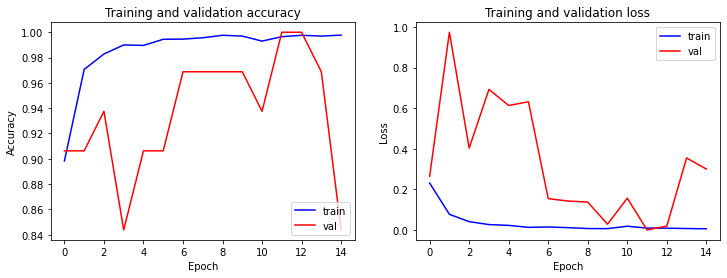

In [15]:

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))


plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')


plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation

In [16]:

test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

threshold = 0.5  
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes



7580/7580 [==============================] - 162s 21ms/step - loss: 0.1036 - acc: 0.9786
Test results Accuracy: 97.86% and Loss: 97.86
7580/7580 [==============================] - 106s 14ms/step


In [17]:
print(f"Label\t\t: {y_true[:50]}")
print(f"Prediction\t: {y_pred[:50]}")

Label		: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0]


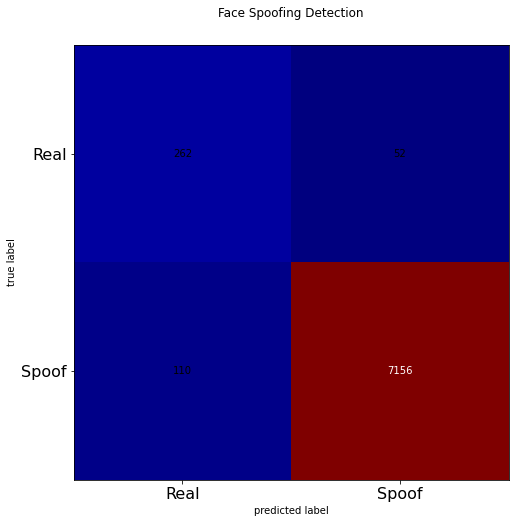

Report Summary:
Precision	: 99.28%
Recall		: 98.49%
F1 Score	: 98.88%

Notes: 
True labels	: Spoof
False labels	: Real


In [18]:

confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()


tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")


In [22]:
model.save("face_antispoofing_model.h5" , '/kaggle/working')

In [23]:
from tensorflow.keras.models import load_model
import numpy as np
model=load_model("/kaggle/working/face_antispoofing_model.h5")

[0.99957424]


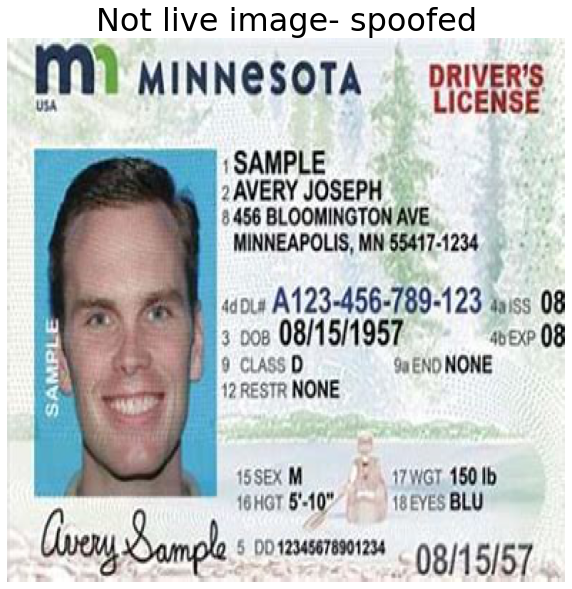

In [24]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/pic1212.jfif"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

image_path = '/kaggle/input/testing/pic1212.jfif'
img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()


[0.9129534]


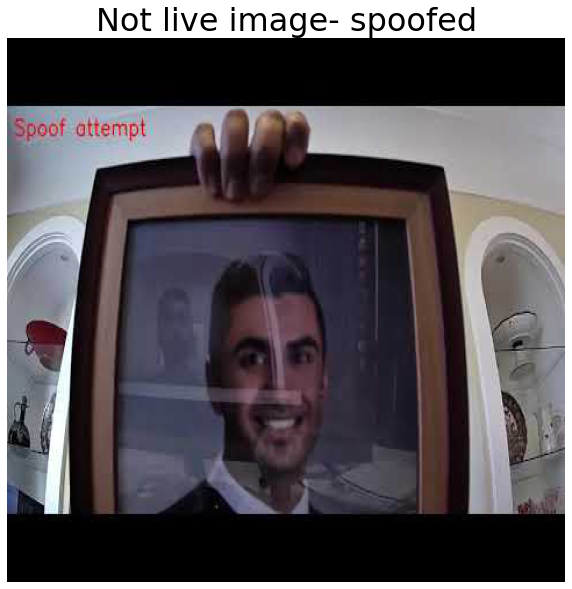

In [25]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/pic1212n.jpg"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()


[0.9999831]


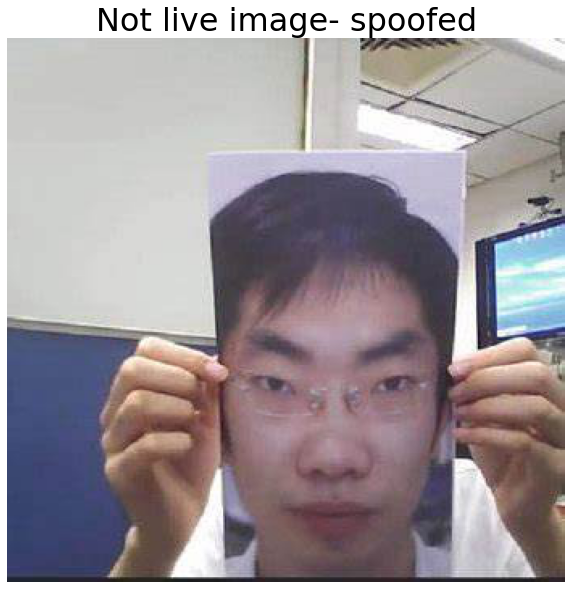

In [26]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/pic1313n.jfif"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()


[0.5006652]


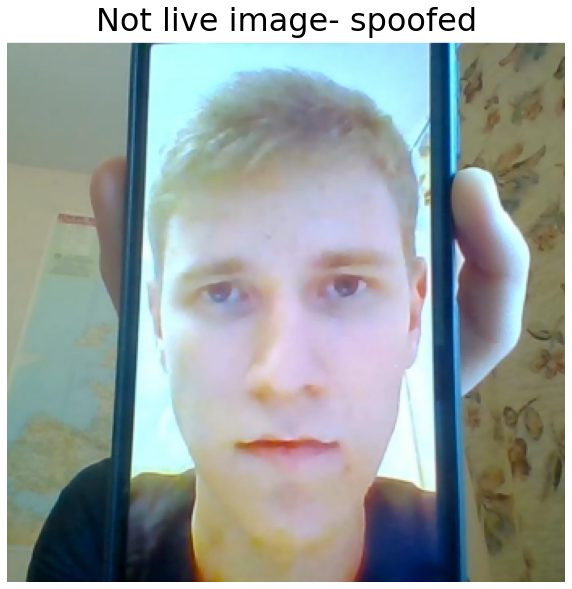

In [29]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/pic1414n.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()


[0.00118701]


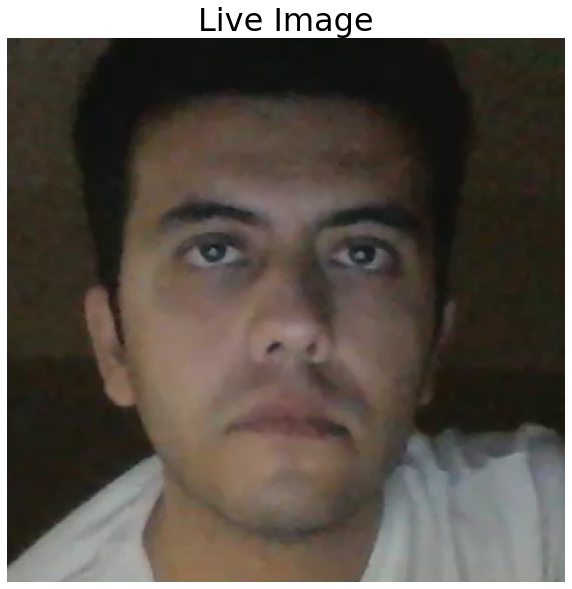

In [30]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/real_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()


[0.00187797]


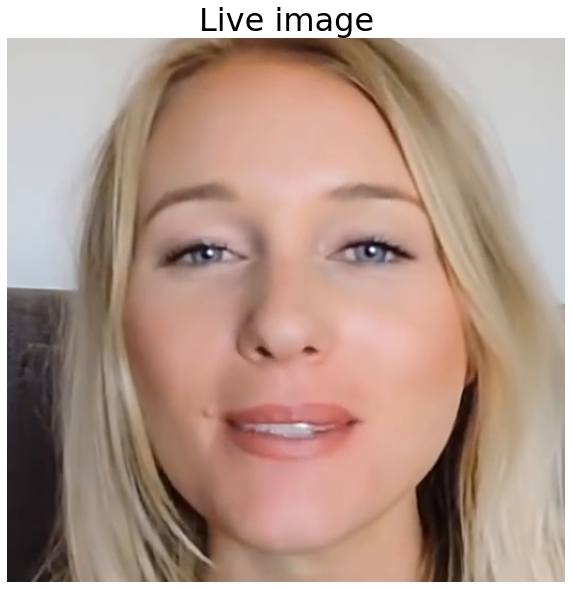

In [31]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "/kaggle/input/testing/real_119.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()
